In [1]:
import numpy as np
import cv2
import threading
import time
import matplotlib.pyplot as plt

In [2]:
BGR_COLOR = {
    'red': (0,0,255),
    'green': (127,255,0),
    'blue': (255,127,0),
    'yellow': (0,127,255),
    'black': (0,0,0),
    'white': (255,255,255)
}

In [3]:
class WebcamVideoStream:
    
    def __init__(self, src=0, api=None):
        self.stream = cv2.VideoCapture(src, api) if api else cv2.VideoCapture(src)
        
        self.stream.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))
        self.stream.set(cv2.CAP_PROP_FRAME_WIDTH, 1024)
        self.stream.set(cv2.CAP_PROP_FRAME_HEIGHT, 768)
        self.stream.set(cv2.CAP_PROP_FPS, 20)
        self.stream.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))
        #self.stream.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('H', '2', '6', '4'))
                
        print("W:H - %s:%s" % (self.stream.get(cv2.CAP_PROP_FRAME_WIDTH), self.stream.get(cv2.CAP_PROP_FRAME_HEIGHT)))
        print("FPS: %s" % self.stream.get(cv2.CAP_PROP_FPS))
        print(self.stream.get(cv2.CAP_PROP_FOURCC))
        print(self.stream.get(cv2.CAP_PROP_BACKEND))
        
        self.frame = None
        self.stopped = False
        self.frame_counter = []
        
    def start(self):
        threading.Thread(target=self.update, args=()).start()
        return self

    def stop(self):
        self.stopped = True
        self.stream.release()
        
    def update(self):
        while not self.stopped:
            (self.grabbed, self.frame) = self.stream.read()
            self.frame_counter.append(time.time())
            
    def read(self):
        return self.frame

    def get_frame_diffs(self):
        return 1.0/np.diff(np.array(self.frame_counter))
        
    def get_avg_fps(self):
        return self.get_frame_diffs().mean()

In [4]:
class VideoWriter:
    
    def __init__(self, vs):
        self.fps = 20.0
        self.vs = vs
        self.stopped = False
        self.frame_counter = []
        
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.out = cv2.VideoWriter('test_video.avi', fourcc, self.fps, (int(vs.stream.get(3)), int(vs.stream.get(4))))
        
    def start(self):
        self.t_start = time.time()
        threading.Thread(target=self.update, args=()).start()
        return self
    
    def stop(self):
        self.stopped = True
        self.out.release()
        
    def update(self):
        while not self.stopped:
            if time.time() < self.t_start + 1./self.fps * float(len(self.frame_counter)):
                continue

            frame = self.vs.read()
            if frame is not None:
                self.out.write(frame)
                self.frame_counter.append(time.time())
                if len(self.frame_counter) == 1:
                    self.t_start = self.frame_counter[0]
                
    def get_frame_diffs(self):
        return 1.0/np.diff(np.array(self.frame_counter))
        
    def get_avg_fps(self):
        return self.get_frame_diffs().mean()                

In [5]:
class PositionTracker:
    
    def __init__(self, video_streamer, background_file='background.png'):
        self.video_streamer = video_streamer
        self.background = cv2.imread(background_file, 1)
        self.fps = 20.0
        self.x, self.y = None, None
        self.contour = []
        self.stopped = False
        self.frame_counter = []
        
        self.mask = np.zeros(shape=self.background.shape, dtype="uint8")
        cv2.circle(self.mask, (512, 384), 350, BGR_COLOR['white'], -1)
        
    def start(self):
        self.t_start = time.time()
        threading.Thread(target=self.update, args=()).start()
        return self
    
    def stop(self):
        self.stopped = True
        
    def update(self):
        while not self.stopped:
            if time.time() < self.t_start + 1./self.fps * float(len(self.frame_counter)):
                continue

            frame = self.video_streamer.read()
            if frame is not None:
                self.detect_position(frame)
                self.frame_counter.append(time.time())
                if len(self.frame_counter) == 1:
                    self.t_start = self.frame_counter[0]
                
    def get_frame_diffs(self):
        return 1.0/np.diff(np.array(self.frame_counter))
        
    def get_avg_fps(self):
        return self.get_frame_diffs().mean()          
       
    def detect_position(self, frame):
        masked_frame = cv2.bitwise_and(src1=frame, src2=self.mask)

        # Substracts background from current frame
        subject = cv2.subtract(masked_frame, self.background)

        # Converts subject to grey scale
        subject_gray = cv2.cvtColor(subject, cv2.COLOR_BGR2GRAY)

        # Applies blur and thresholding to the subject
        kernel_size = (25,25)
        frame_blur = cv2.GaussianBlur(subject_gray, kernel_size, 0)
        _, thresh = cv2.threshold(frame_blur, 40, 255, cv2.THRESH_BINARY)

        # Finds contours and selects the contour with the largest area
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        if len(contours) == 0:
            return
        contour = contours[np.argmax(list(map(cv2.contourArea, contours)))]
        M = cv2.moments(contour)
        if (M['m00'] == 0):
            return

        self.x = int(M['m10'] / M['m00'])
        self.y = int(M['m01'] / M['m00'])
        self.contour = contour

In [6]:
# check camera output formats with FFMPEG
# https://stackoverflow.com/questions/15301608/how-to-query-a-webcams-output-formats
#
# ffmpeg -list_devices true -f dshow -i dummy
# ffmpeg -list_options true -f dshow -i video="HD USB Camera"

In [11]:
# https://stackoverflow.com/questions/39308664/opencv-cant-set-mjpg-compression-for-usb-camera
del vs
del vw
del pt

vs = WebcamVideoStream(src=0, api=cv2.CAP_DSHOW)  # for IR usb camera api=cv2.CAP_DSHOW
vs.start()

vw = VideoWriter(vs)
vw.start()

pt = PositionTracker(vs)
pt.start()

try:
    while True:
        time.sleep(0.05)
        frame = vs.read()
        if frame is not None:
            if pt.x is not None:
                frame = cv2.circle(frame, (pt.x, pt.y), 3, BGR_COLOR['yellow'], -1)
            cv2.imshow("Frame", frame)

        k = cv2.waitKey(33)
        if k == ord('q'):
            break
finally:
    cv2.destroyAllWindows()
    pt.stop()
    vw.stop()
    vs.stop()

W:H - 1024.0:768.0
FPS: 20.0
1196444237.0
700.0


In [12]:
vs.get_avg_fps(), vw.get_avg_fps(), pt.get_avg_fps()

(20.454321445333584, 20.074599414918435, 22.790910551179692)

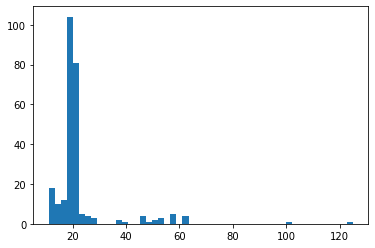

In [13]:
_ = plt.hist(pt.get_frame_diffs(), 50)

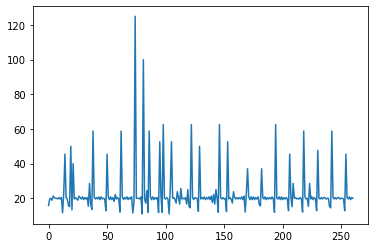

In [15]:
plt.plot(pt.get_frame_diffs())